In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import re

theses_per_page = 50

def get_urls(n_pages):
    data = {'lang': 'en', 'FAK': 6410, 'PRI': '-', 'TIT': '-', 'PRA': '-', 'vypsat': 1, 'exppar': 1, 'por': 1}
    urls = []
    for por in range (1, n_pages*theses_per_page, theses_per_page): 
        data['por'] = por
        page = requests.get('https://is.vsfs.cz/thesis/', params=data)
        soup = BeautifulSoup(page.text, 'html.parser')
        theses_info = soup.find_all('div', attrs={'style': 'margin-left:50px'}) # get information about the theses
        
        for i in range (0, theses_per_page-1, 1): # there are information about 50 theses on each page
            line_with_url = theses_info[i].find('a') # get the line with url
            
            if(line_with_url): # the line with url is not always there
                url_list = re.findall('href="([^"]*)"', str(line_with_url)) # get the url 
                url = 'https://is.vsfs.cz' + url_list[0]
                urls.append(url)   
    return urls
            
def parse_thesis(url):
    page = requests.get(url)
    soup = BeautifulSoup(page.text, 'html.parser')

    # div with id='metadata' contains author's name and title of the thesis
    metadata = soup.find(id='metadata')
    
    # there is an antiscraping protection on the website, which limits us to ~180 accesses in a short timeframe
    # we are good guys, so we wouldn't want to exploit some kind of captcha-reading library,
    # therefore we have to manually enter the captcha after every ~180 thesis pages accessed
    if(not metadata): # if there is no metadata on the page, we've been redirected to the antiscraping page
        input('Fill in captcha on the antiscraping page and press any key:')
        # after we fill in the captcha, we have to load the thesis page again
        page = requests.get(url)
        soup = BeautifulSoup(page.text, 'html.parser')
        metadata = soup.find(id='metadata')

    author = metadata.find('h3').get_text() # author's name is tagged as 'h3' 

    title = metadata.find('h2') # title is tagged as 'h2'
    title = title.get_text()

    # 3rd div with class='oddil' contains level (bachelor or master), date, advisor and opponent
    oddil = soup.find_all(class_='oddil')
    oddil = oddil[2]

    # we can parse the level of the thesis from a line tagged as 'h3'
    level_line = oddil.find('h3').get_text()
    level = parse_level(level_line)

    # the line containing date of defense is the first field tagged as 'ul'
    try:
        date_line = oddil.find_all('ul')[0].get_text()
        year = parse_year(date_line)
    except IndexError: # if the field with date is missing
        year = np.nan

    # the line containing supervisor is the second field tagged as 'ul'
    try:
        supervisor_line = oddil.find_all('ul')[1].get_text()
        supervisor = parse_name(supervisor_line)
    except IndexError: # if the field with supervisor is missing
        supervisor = np.nan

    # the line containing reader is the third field tagged as 'ul'
    try:
        reader_line = oddil.find_all('ul')[2].get_text()
        reader = parse_name(reader_line)
    except IndexError: # if the field with reader is missing
        reader = np.nan
    
    return {'Author': author, 'Title': title, 'Level': level, 'Year': year, 'Supervisor': supervisor, 'Reader': reader}
    #return author, title, level, year, supervisor, reader

def parse_level(line):
    if "Bachelor" in line:
        level = "Bachelor"
    elif "Master" in line:
        level = "Master"
    elif "Dissertation" in line:
        level = "Dissertation"
    else:
        level = np.nan
    return level

def parse_year(line):
    if "Pending" in line: # if the thesis haven't been defended yet
        return np.nan
    date = re.findall(r'\d+', line) # get numbers from the line
    year = date[2] # year is the 3rd field (format of the date was dd. mm. yyyy)
    return year

def parse_name(line):
    line = line.split(', ') 
    # there is some noise on this line, but degrees are not longer than 5 characters, so remove everything longer than 5
    degrees = [degree for degree in line if len(degree)<6]
    name_degrees = [line[0]] + degrees # first field contains the name and degrees in front of the name
    name = ', '.join(name_degrees[:]) # stitch the name and degrees together
    name = name.replace('\n','') # sometimes there is '\n' at the end of the name, we don't want that
    return name

def parse_theses(urls):
    theses = []
    for url in urls: 
        theses.append(parse_thesis(url))     
    return theses

urls = get_urls(100)
theses = parse_theses(urls)

In [ ]:
import pandas as pd

df = pd.DataFrame(theses)
df = df[['Author', 'Title', 'Level', 'Year', 'Supervisor', 'Reader']]  # rearrange columns
df.to_csv('theses.csv')
df.tail()

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('theses.csv')
df = df.dropna() # remove rows with missing values
df['Year'] = df['Year'].astype(int) # change Year's type to int
df = df.drop(['Unnamed: 0'], axis=1) # drop duplicate index column
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4369 entries, 0 to 4843
Data columns (total 6 columns):
Author        4369 non-null object
Title         4369 non-null object
Level         4369 non-null object
Year          4369 non-null int64
Supervisor    4369 non-null object
Reader        4369 non-null object
dtypes: int64(1), object(5)
memory usage: 238.9+ KB


In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 

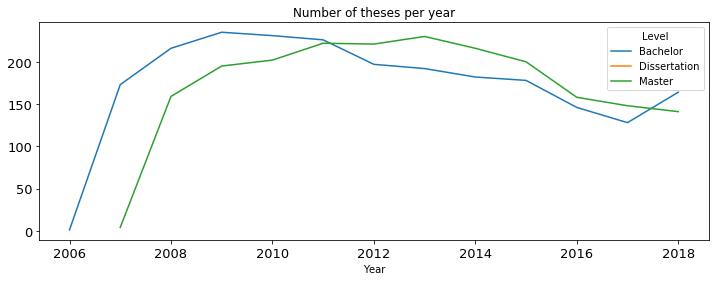

In [3]:
#1) Časový vývoj (po rocích) počtu obhájených prací (vč. rozlišení jejich typu).

theses_per_year = df.groupby(['Year', 'Level']).size().unstack() # unstack() is used so that the plot is shown correctly
theses_per_year.plot(kind="line", title='Number of theses per year', figsize=[12,4], fontsize = 13)

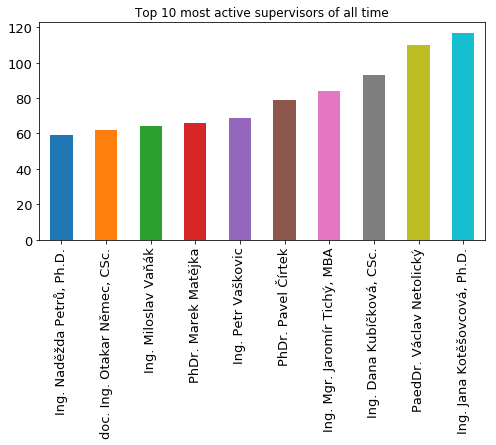

In [4]:
#2a) Nejpilnější vedoucí - počet vedených prací za celou dobu

# count how many times each supervisor is present, sort the result and get the top 10
most_active_supervisors_all_time = pd.value_counts(df['Supervisor'], sort=True, ascending=True).tail(10)
most_active_supervisors_all_time.plot(kind="bar", title="Top 10 most active supervisors of all time", figsize=[8,4], fontsize = 13)

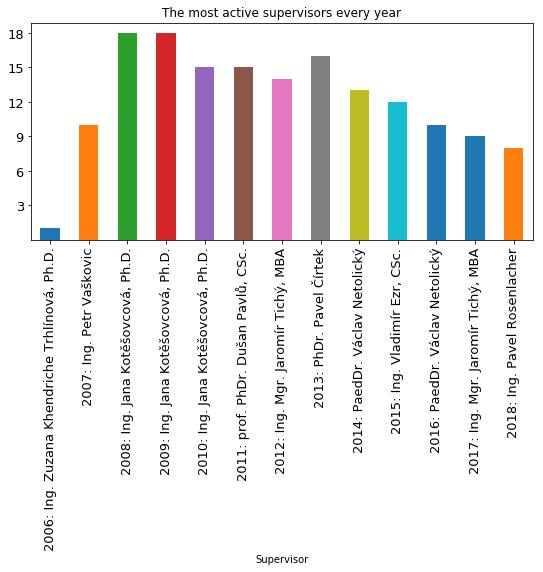

In [5]:
#2b) Nejpilnější vedoucí - počet vedených prací na rok

# add a column with count of supervised theses per year for each supervisor
most_active_supervisors_per_year = pd.crosstab(df.Year,df.Supervisor).stack().reset_index().rename(columns={0:'Count'})
# sort by Count and Year, remove Year duplicates (so we get the data we want) and sort again by Year
most_active_supervisors_per_year = most_active_supervisors_per_year.sort_values(['Count','Year'], ascending=False).drop_duplicates(['Year']).sort_values(['Year'], ascending=True)
# add information about the year
most_active_supervisors_per_year["Supervisor"] = most_active_supervisors_per_year["Year"].map(str) + ": " + most_active_supervisors_per_year["Supervisor"]
most_active_supervisors_per_year.plot(kind='bar', x='Supervisor', y='Count', legend=False, yticks=[3, 6, 9, 12, 15, 18]
                                        , title='The most active supervisors every year', figsize=[9,4], fontsize = 13)

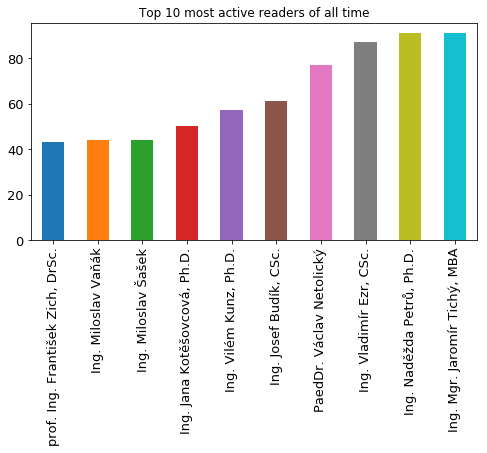

In [6]:
#3a) Nejpilnější oponenti - počet oponovaných prací za celou dobu

# count how many times each reader is present, sort the result and get the top 10
most_active_readers_all_time = pd.value_counts(df['Reader'], sort=True, ascending=True).tail(10)
most_active_readers_all_time.plot(kind="bar", title="Top 10 most active readers of all time", figsize=[8,4], fontsize = 13)

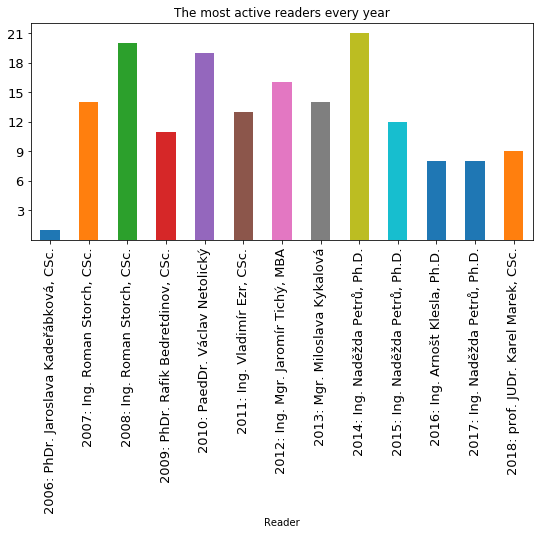

In [7]:
#3b) Nejpilnější oponenti - počet oponovaných prací na rok

# add a column with count of read theses per year for each reader
most_active_readers_per_year = pd.crosstab(df.Year,df.Reader).stack().reset_index().rename(columns={0:'Count'})
# sort by Count and Year, remove Year duplicates (so we get the data we want) and sort again by Year
most_active_readers_per_year = most_active_readers_per_year.sort_values(['Count','Year'], ascending=False).drop_duplicates(['Year']).sort_values(['Year'], ascending=True)
# add information about the year
most_active_readers_per_year["Reader"] = most_active_readers_per_year["Year"].map(str) + ": " + most_active_readers_per_year["Reader"]
most_active_readers_per_year.plot(kind='bar', x='Reader', y='Count', legend=False, yticks=[3, 6, 9, 12, 15, 18, 21]
                                        , title='The most active readers every year', figsize=[9,4], fontsize = 13)

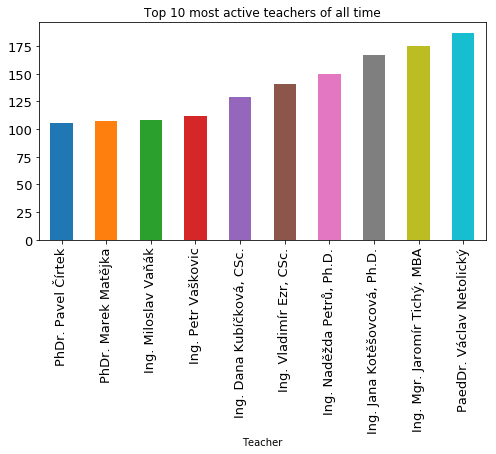

In [8]:
#4a) Nejpilnější z nejpilnějších - počet vedených a oponovaných prací za celou dobu

# add a column with count of how many times is each supervisor present
most_active_supervisors_all_time = df.loc[:, ['Supervisor']]
most_active_supervisors_all_time['supervisor_count'] = df.groupby('Supervisor')['Supervisor'].transform('count')

# add a column with count of how many times is each reader present
most_active_readers_all_time = df.loc[:, ['Reader']]
most_active_readers_all_time['reader_count'] = df.groupby('Reader')['Reader'].transform('count')

# merge supervisor and reader datasets
most_active_supervisors_all_time = most_active_supervisors_all_time.rename(columns={'Supervisor': 'Teacher'})
most_active_readers_all_time = most_active_readers_all_time.rename(columns={'Reader': 'Teacher'})
most_active_teachers_all_time = pd.merge(most_active_supervisors_all_time, most_active_readers_all_time, on=['Teacher'])
most_active_teachers_all_time = most_active_teachers_all_time.drop_duplicates('Teacher')

most_active_teachers_all_time['Count'] = most_active_teachers_all_time['supervisor_count'] + most_active_teachers_all_time['reader_count']

most_active_teachers_all_time = most_active_teachers_all_time.sort_values(by=['Count'], ascending=True).tail(10)

most_active_teachers_all_time.plot(x='Teacher', y='Count', kind="bar", title="Top 10 most active teachers of all time", figsize=[8,4], fontsize = 13, legend=False)

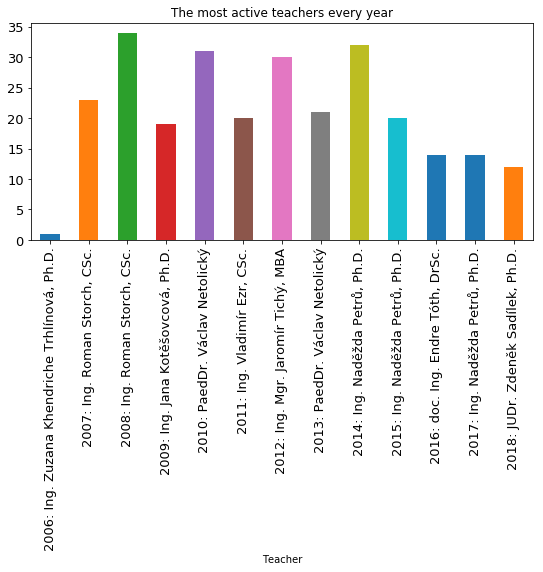

In [9]:
#4b) Nejpilnější z nejpilnějších - počet vedených a oponovaných prací na rok

# add a column with count of supervised theses per year for each supervisor
most_active_supervisors_per_year = pd.crosstab(df.Year,df.Supervisor).stack().reset_index().rename(columns={0:'supervisor_count'})
most_active_supervisors_per_year = most_active_supervisors_per_year.sort_values(['Year', 'Supervisor'])
# add a column with count of read theses per year for each reader
most_active_readers_per_year = pd.crosstab(df.Year,df.Reader).stack().reset_index().rename(columns={0:'reader_count'})
most_active_readers_per_year = most_active_readers_per_year.sort_values(['Year', 'Reader'])

# merge supervisor and reader datasets
most_active_supervisors_per_year = most_active_supervisors_per_year.rename(columns={'Supervisor': 'Teacher'})
most_active_readers_per_year = most_active_readers_per_year.rename(columns={'Reader': 'Teacher'})
most_active_teachers_per_year = pd.merge(most_active_supervisors_per_year, most_active_readers_per_year, on=['Teacher', 'Year'])

most_active_teachers_per_year['Count'] = most_active_teachers_per_year['supervisor_count'] + most_active_teachers_per_year['reader_count']

# sort by Count and Year, remove Year duplicates (so we get the data we want) and sort again by Year
most_active_teachers_per_year = most_active_teachers_per_year.sort_values(['Count','Year'], ascending=False).drop_duplicates(['Year']).sort_values(['Year'], ascending=True)
# rename a column
most_active_teachers_per_year = most_active_teachers_per_year.rename(columns={'Supervisor': 'Teacher'})
# add information about the year
most_active_teachers_per_year["Teacher"] = most_active_teachers_per_year["Year"].map(str) + ": " + most_active_teachers_per_year["Teacher"]
most_active_teachers_per_year.plot(kind='bar', x='Teacher', y='Count', legend=False
                                        , title='The most active teachers every year', figsize=[9,4], fontsize = 13)

In [10]:
#5a) Průměrný počet (medián, minimum, maximum, rozptyl) prací na vedoucího

# add a column with count of how many times is each supervisor present
supervisor_count = df.loc[:, ['Supervisor']]
supervisor_count['Count'] = df.groupby('Supervisor')['Supervisor'].transform('count')
supervisor_count = supervisor_count.drop_duplicates('Supervisor')

supervisor_count.Count.agg(['mean', 'median', 'min', 'max', 'std'])

mean        9.315565
median      3.000000
min         1.000000
max       117.000000
std        15.177954
Name: Count, dtype: float64

In [11]:
#5b) Průměrný počet (medián, minimum, maximum, rozptyl) prací na oponenta

# add a column with count of how many times is each reader present
reader_count = df.loc[:, ['Reader']]
reader_count['Count'] = df.groupby('Reader')['Reader'].transform('count')
reader_count = reader_count.drop_duplicates('Reader')

reader_count.Count.agg(['mean', 'median', 'min', 'max', 'std'])

mean       6.017906
median     2.000000
min        1.000000
max       91.000000
std       10.582534
Name: Count, dtype: float64

In [12]:
#5c) Průměrný počet (medián, minimum, maximum, rozptyl) prací na rok

year_count = df.loc[:, ['Year']]
year_count['Count'] = df.groupby('Year')['Year'].transform('count')
year_count = year_count.drop_duplicates('Year')

year_count.Count.agg(['mean', 'median', 'min', 'max', 'std'])

mean      336.076923
median    379.000000
min         1.000000
max       448.000000
std       127.620180
Name: Count, dtype: float64

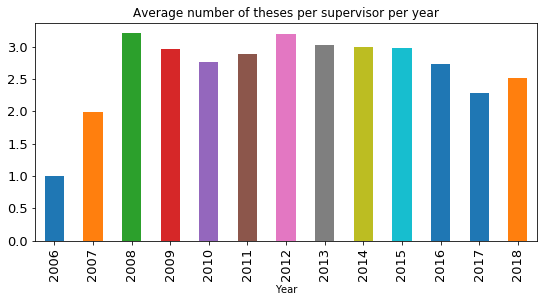

In [13]:
#5d) a další informace o rozložení vedení prací na školitele
#    Průměrný počet prací na vedoucího na rok

# get number of theses for each year
year_count = df.loc[:, ['Year']]
year_count['year_count'] = df.groupby('Year')['Year'].transform('count')
year_count = year_count.drop_duplicates('Year')

supervisors_per_year_count = df.loc[:, ['Year', 'Supervisor']]
supervisors_per_year_count = supervisors_per_year_count.drop_duplicates(subset=['Year', 'Supervisor'])

# get number of supervisors for each year, drop duplicate years and drop supervisor column as we don't need it anymore
supervisors_per_year_count['supervisors_count'] = supervisors_per_year_count.groupby(['Year']).transform(np.size)
supervisors_per_year_count = supervisors_per_year_count.drop_duplicates(['Year'])
supervisors_per_year_count = supervisors_per_year_count.drop(['Supervisor'], axis=1)

theses_per_supervisor_per_year = pd.merge(year_count, supervisors_per_year_count , on=['Year'])
# count the average number of theses per reader per year
theses_per_supervisor_per_year['mean'] = theses_per_supervisor_per_year['year_count'] / theses_per_supervisor_per_year['supervisors_count']
theses_per_supervisor_per_year.sort_values(by=['Year'], inplace=True, ascending=True)

theses_per_supervisor_per_year.plot(x='Year', y='mean', kind='bar', legend=False
                                        , title='Average number of theses per supervisor per year', figsize=[9,4], fontsize = 13)

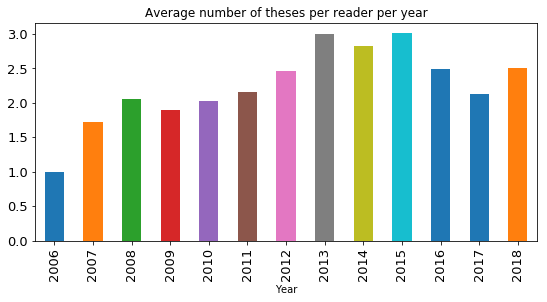

In [14]:
#5e) a další informace o rozložení vedení prací na školitele
#    Průměrný počet prací na oponenta na rok

# get number of theses for each year
year_count = df.loc[:, ['Year']]
year_count['year_count'] = df.groupby('Year')['Year'].transform('count')
year_count = year_count.drop_duplicates('Year')

readers_per_year_count = df.loc[:, ['Year', 'Reader']]
readers_per_year_count = readers_per_year_count.drop_duplicates(subset=['Year', 'Reader'])

# get number of readers for each year, drop duplicate years and drop reader column as we don't need it anymore
readers_per_year_count['readers_count'] = readers_per_year_count.groupby(['Year']).transform(np.size)
readers_per_year_count = readers_per_year_count.drop_duplicates(['Year'])
readers_per_year_count = readers_per_year_count.drop(['Reader'], axis=1)

theses_per_reader_per_year = pd.merge(year_count, readers_per_year_count , on=['Year'])
# count the average number of theses per reader per year
theses_per_reader_per_year['mean'] = theses_per_reader_per_year['year_count'] / theses_per_reader_per_year['readers_count']
theses_per_reader_per_year.sort_values(by=['Year'], inplace=True, ascending=True)

theses_per_reader_per_year.plot(x='Year', y='mean', kind='bar', legend=False
                                        , title='Average number of theses per reader per year', figsize=[9,4], fontsize = 13)

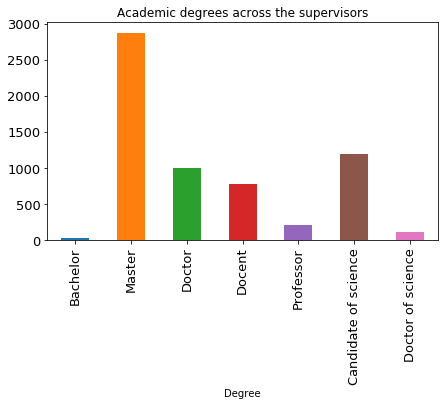

In [15]:
#6a) Rozložení vedoucích prací podle titulů (bakalářský titul, magisterský titul, doktorský titul, docent, profesor, atp.).

# this is not a very nice solution, but it works :)

bachelors = df[(df['Supervisor'].str.find('Bc.') != -1)].count()
bachelors = bachelors['Supervisor']

masters = df[(df['Supervisor'].str.find('Mgr.') != -1) | (df['Supervisor'].str.find('Ing.') != -1)].count()
masters = masters['Supervisor']

doctors = df[(df['Supervisor'].str.find('Ph.D.') != -1)].count()
doctors = doctors['Supervisor']

docents = df[(df['Supervisor'].str.find('doc.') != -1)].count()
docents = docents['Supervisor']

professors = df[(df['Supervisor'].str.find('prof.') != -1)].count()
professors = professors['Supervisor']

candidates_of_science = df[(df['Supervisor'].str.find('CSc.') != -1)].count()
candidates_of_science = candidates_of_science['Supervisor']

doctors_of_science = df[(df['Supervisor'].str.find('DrSc.') != -1)].count()
doctors_of_science = doctors_of_science['Supervisor']


supervisors_degrees = pd.DataFrame(columns=['Degree', 'Count'])
supervisors_degrees.loc[0] = ['Bachelor', bachelors]
supervisors_degrees.loc[1] = ['Master', masters]
supervisors_degrees.loc[2] = ['Doctor', doctors]
supervisors_degrees.loc[3] = ['Docent', docents]
supervisors_degrees.loc[4] = ['Professor', professors]
supervisors_degrees.loc[5] = ['Candidate of science', candidates_of_science]
supervisors_degrees.loc[6] = ['Doctor of science', doctors_of_science]
supervisors_degrees[['Count']] = supervisors_degrees[['Count']].apply(pd.to_numeric)
supervisors_degrees.plot(x='Degree', y='Count', kind='bar', legend=False
                                        , title='Academic degrees across the supervisors', figsize=[7,4], fontsize=13)

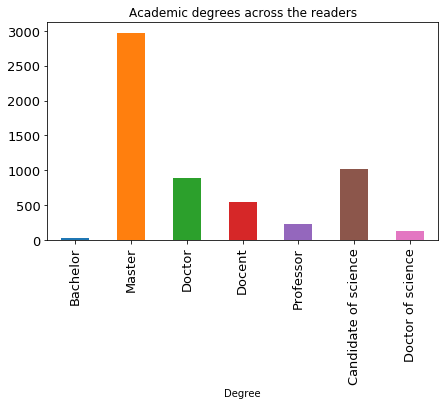

In [16]:
#6b) Rozložení oponentů prací podle titulů (bakalářský titul, magisterský titul, doktorský titul, docent, profesor, atp.).

# this is not a very nice solution, but it works :)

bachelors = df[(df['Reader'].str.find('Bc.') != -1)].count()
bachelors = bachelors['Reader']

masters = df[(df['Reader'].str.find('Mgr.') != -1) | (df['Reader'].str.find('Ing.') != -1)].count()
masters = masters['Reader']

doctors = df[(df['Reader'].str.find('Ph.D.') != -1)].count()
doctors = doctors['Reader']

docents = df[(df['Reader'].str.find('doc.') != -1)].count()
docents = docents['Reader']

professors = df[(df['Reader'].str.find('prof.') != -1)].count()
professors = professors['Reader']

candidates_of_science = df[(df['Reader'].str.find('CSc.') != -1)].count()
candidates_of_science = candidates_of_science['Reader']

doctors_of_science = df[(df['Reader'].str.find('DrSc.') != -1)].count()
doctors_of_science = doctors_of_science['Reader']


readers_degrees = pd.DataFrame(columns=['Degree', 'Count'])
readers_degrees.loc[0] = ['Bachelor', bachelors]
readers_degrees.loc[1] = ['Master', masters]
readers_degrees.loc[2] = ['Doctor', doctors]
readers_degrees.loc[3] = ['Docent', docents]
readers_degrees.loc[4] = ['Professor', professors]
readers_degrees.loc[5] = ['Candidate of science', candidates_of_science]
readers_degrees.loc[6] = ['Doctor of science', doctors_of_science]
readers_degrees[['Count']] = readers_degrees[['Count']].apply(pd.to_numeric)
readers_degrees.plot(x='Degree', y='Count', kind='bar', legend=False
                                        , title='Academic degrees across the readers', figsize=[7,4], fontsize=13)

In [17]:
#7) Zobrazte tabulku (a případně i jiné věci) v Jupyter notebooku pomocí http://beakerx.com.
from beakerx import * 

table = TableDisplay(df)
table.setAlignmentProviderForColumn('Author', TableDisplayAlignmentProvider.CENTER_ALIGNMENT)
table.setAlignmentProviderForColumn('Supervisor', TableDisplayAlignmentProvider.CENTER_ALIGNMENT)
table.setAlignmentProviderForColumn('Reader', TableDisplayAlignmentProvider.CENTER_ALIGNMENT)
#table.addCellHighlighter(TableDisplayCellHighlighter.getHeatmapHighlighter('Year', TableDisplayCellHighlighter.FULL_ROW))
table

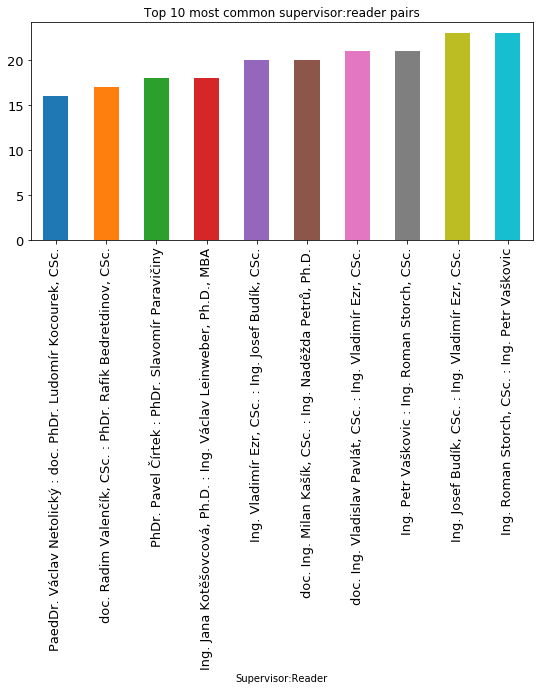

In [18]:
#8a) Nejčastější dvojice vedoucí:oponent

# add a column with count of how many times each supervisor was on the same thesis as each reader
most_common_supervisor_reader_pair = pd.crosstab(df.Supervisor, df.Reader).stack().reset_index().rename(columns={0: 'Count'})
# sort the result and get the top 10
most_common_supervisor_reader_pair = most_common_supervisor_reader_pair.sort_values('Count', ascending=True).tail(10)
most_common_supervisor_reader_pair['Supervisor:Reader'] = most_common_supervisor_reader_pair['Supervisor'] + ' : ' + most_common_supervisor_reader_pair['Reader']
most_common_supervisor_reader_pair.plot(x='Supervisor:Reader', y='Count', kind='bar', legend=False
                                        , title='Top 10 most common supervisor:reader pairs', figsize=[9,4], fontsize = 13)

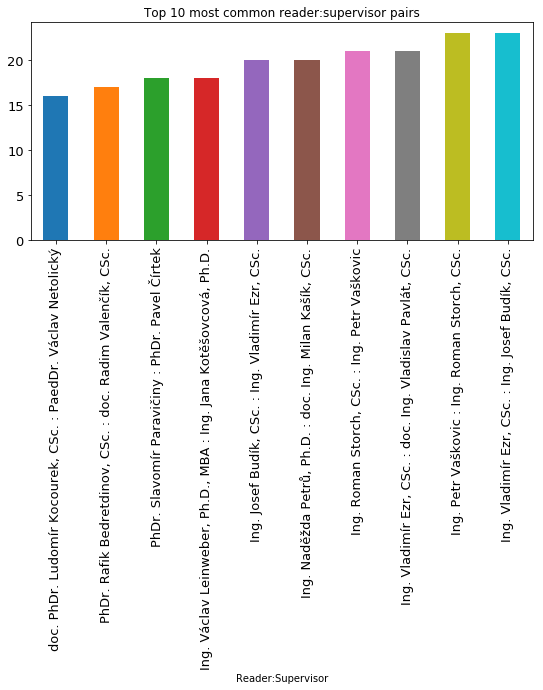

In [19]:
#8b) Nejčastější dvojice oponent:vedoucí

# add a column with count of how many times each supervisor was on the same thesis as each reader
most_common_reader_supervisor_pair = pd.crosstab(df.Reader, df.Supervisor).stack().reset_index().rename(columns={0: 'Count'})
# sort the result and get the top 10
most_common_reader_supervisor_pair = most_common_reader_supervisor_pair.sort_values('Count', ascending=True).tail(10)
most_common_reader_supervisor_pair['Reader:Supervisor'] = most_common_reader_supervisor_pair['Reader'] + ' : ' + most_common_reader_supervisor_pair['Supervisor']
most_common_reader_supervisor_pair.plot(x='Reader:Supervisor', y='Count', kind='bar', legend=False
                                        , title='Top 10 most common reader:supervisor pairs', figsize=[9,4], fontsize = 13)

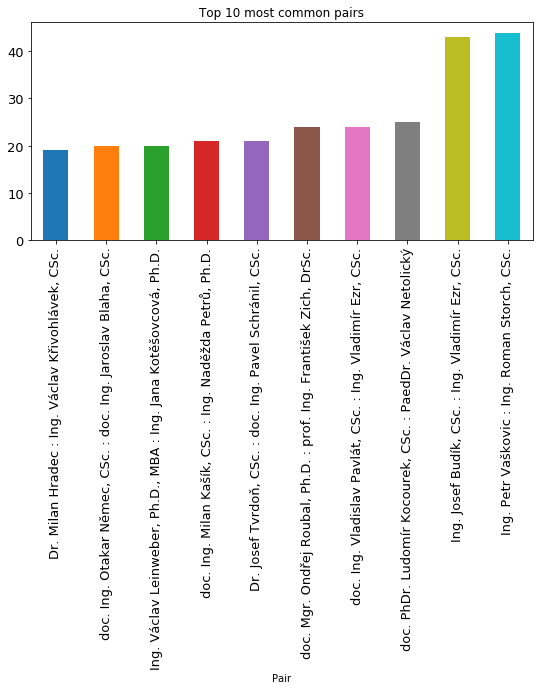

In [20]:
#8c) Nejčastěji spolupracující dvojice

# get data for both supervisor : reader and reader : supervisor
most_common_supervisor_reader_pair = pd.crosstab(df.Supervisor, df.Reader).stack().reset_index().rename(columns={0: 'supervisor_reader_count'})
most_common_reader_supervisor_pair = pd.crosstab(df.Reader, df.Supervisor).stack().reset_index().rename(columns={0: 'reader_supervisor_count'})

# if we woudln't rename the columns we would get the same counts twice
most_common_reader_supervisor_pair.rename(columns={"Supervisor": "tmp", "Reader": "Supervisor"}, inplace=True)
most_common_reader_supervisor_pair.rename(columns={"tmp": "Reader"}, inplace=True)

most_common_pair = pd.merge(most_common_supervisor_reader_pair, most_common_reader_supervisor_pair, on=['Supervisor', 'Reader'])
most_common_pair['Count'] = most_common_pair['supervisor_reader_count'] + most_common_pair['reader_supervisor_count']

# each pair is shown twice, so we get the top 20 and extract odd rows
most_common_pair = most_common_pair.sort_values(by=['Count'], ascending=True).tail(20).reset_index()
most_common_pair = most_common_pair[1::2]

most_common_pair['Pair'] = most_common_pair['Supervisor'] + ' : ' + most_common_pair['Reader']

most_common_pair.plot(x='Pair', y='Count', kind='bar', legend=False
                                        , title='Top 10 most common pairs', figsize=[9,4], fontsize = 13)